In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.utils import resample
from itertools import product

In [2]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")

In [3]:
derivation_cohort.head()

,Outcome_Occlusion_MI,Age,HR,PR,QRSd,mfpQRSaxis,fpTaxis,txzQRSaxis,QRSTangle,mQRSTangle,...,tamp_III,tamp_aVR,tamp_aVL,tamp_aVF,tamp_V1,tamp_V2,tamp_V3,tamp_V4,tamp_V5,tamp_V6
0,0,78.0,116.0,94.0,107.0,7.0,107.0,79.0,163.0,142.0,...,46.0,0.0,-61.0,63.0,132.0,201.0,319.0,125.0,59.0,-65.0
1,0,84.0,71.0,174.0,136.0,53.0,NaN,51.0,137.0,113.0,...,69.0,51.0,32.0,-72.0,344.0,742.0,668.0,172.0,-153.0,23.0
2,0,76.0,73.0,191.0,110.0,-72.0,56.0,110.0,153.0,147.0,...,50.0,-131.0,29.0,103.0,-50.0,81.0,186.0,155.0,101.0,60.0
3,0,53.0,76.0,134.0,97.0,71.0,58.0,117.0,50.0,78.0,...,195.0,-249.0,-38.0,266.0,-101.0,89.0,450.0,545.0,656.0,272.0
4,0,34.0,76.0,160.0,87.0,43.0,70.0,26.0,45.0,38.0,...,169.0,-150.0,-59.0,199.0,75.0,192.0,128.0,103.0,127.0,150.0


In [4]:
external_validation_cohort.head()

,Outcome_Occlusion_MI,Age,HR,PR,QRSd,mfpQRSaxis,fpTaxis,txzQRSaxis,QRSTangle,mQRSTangle,...,tamp_III,tamp_aVR,tamp_aVL,tamp_aVF,tamp_V1,tamp_V2,tamp_V3,tamp_V4,tamp_V5,tamp_V6
0,0,64,98,NaN,128,35,14.0,-108,23.0,82.0,...,-105,-176,151,80,-242,-129,-98,272,307,270
1,1,64,76,166.0,95,3,98.0,111,56.0,83.0,...,136,77,-129,143,198,386,469,-147,-140,-106
2,0,55,65,NaN,125,-77,63.0,76,137.0,134.0,...,138,-166,21,186,-159,178,186,144,107,85
3,0,58,67,248.0,79,79,44.0,28,32.0,38.0,...,48,-102,-22,84,-33,89,205,179,115,58
4,0,40,111,140.0,103,54,-22.0,-179,27.0,17.0,...,-108,-51,112,-8,-53,29,87,129,-77,-62


In [5]:
y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

y_val = external_validation_cohort['Outcome_Occlusion_MI']
X_val = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_84052\3933838254.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_84052\3933838254.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [6]:
def get_xgb_classifier(params=None, calibrate=False, cv=5):
    """
    Returns an XGBClassifier with default or custom parameters.
    
    Args:
        params (dict): Dictionary of parameters to override defaults.
        calibrate (bool): Whether to apply isotonic calibration.
        cv (int): Number of cross-validation folds for calibration.
        
    Returns:
        XGBClassifier or CalibratedClassifierCV object.
    """
    default_params = {
        "n_estimators": 20,
        "learning_rate": 0.1,
        "max_depth": 6,
        "min_child_weight": 1,
        "gamma": 1e-2,
        "colsample_bytree": 0.7,
        "subsample": 0.75,
        "reg_alpha": 1e-2,
        "tree_method": "hist",
        "n_jobs": -1,
        "random_state": 42
    }
    
    if params:
        default_params.update(params)  # Override defaults with provided values
    
    clf = XGBClassifier(**default_params)
    
    if calibrate:
        clf = CalibratedClassifierCV(clf, cv=cv, method="isotonic")
    
    return clf

In [7]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'XGB (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [9]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from itertools import product
import numpy as np
import json

def xgb_hyperparameter_tuning_cv(X, y, param_grid=None, n_folds=10, random_state=42):
    """
    Perform hyperparameter tuning for XGBClassifier using K-fold cross-validation.
    
    Args:
        X, y: Training data (numpy arrays or pandas DataFrames)
        param_grid (dict): Dictionary of hyperparameter lists to search
        n_folds (int): Number of folds for cross-validation
        random_state (int): Random seed for reproducibility
        
    Returns:
        best_params: The best hyperparameters found
        best_score: Best mean AUROC score
        cv_results: Detailed results for all parameter combinations
    """
    print(f"Hyperparameter Tuning with {n_folds}-fold Cross-Validation")
    
    # Convert to numpy arrays if they are not already
    if hasattr(X, 'values'):
        X = X.values
    if hasattr(y, 'values'):
        y = y.values
    
    # Minimal grid if not provided
    if param_grid is None:
        param_grid = {
            "n_estimators": [50, 100],
            "max_depth": [3, 4],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8],
            "colsample_bytree": [0.8]
        }
    
    # Set default for optional params if not in grid
    if "reg_alpha" not in param_grid:
        param_grid["reg_alpha"] = [0]
    if "reg_lambda" not in param_grid:
        param_grid["reg_lambda"] = [1]
        
    best_mean_auroc = 0
    best_params = {}
    cv_results = []
    
    # Create KFold object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Total number of parameter combinations
    param_combinations = [len(v) for v in param_grid.values()]
    total_combinations = np.prod(param_combinations)
    print(f"Searching through {total_combinations} parameter combinations...")
    
    # Iterate over all combinations of hyperparameters
    for i, params in enumerate(product(*param_grid.values())):
        param_names = list(param_grid.keys())
        current_params = dict(zip(param_names, params))
        
        print(f"\nParameter combination {i+1}/{total_combinations}:")
        print(f"Params: {current_params}")
        
        # Store fold results
        fold_scores = []
        
        # Perform k-fold cross-validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Train model
            current_xgb = XGBClassifier(
                **current_params,
                tree_method="hist",
                n_jobs=-1,
                random_state=random_state
            )
            
            current_xgb.fit(X_train_fold, y_train_fold)
            
            # Predict probabilities and calculate AUROC
            val_probas = current_xgb.predict_proba(X_val_fold)
            auroc = roc_auc_score(y_val_fold, val_probas[:, 1])
            fold_scores.append(auroc)
            
            print(f"  Fold {fold+1}/{n_folds} - AUROC: {auroc:.4f}")
        
        # Calculate mean and std of AUROC across folds
        mean_auroc = np.mean(fold_scores)
        std_auroc = np.std(fold_scores)
        print(f"  Mean AUROC: {mean_auroc:.4f} ± {std_auroc:.4f}")
        
        # Store results for this parameter combination
        cv_results.append({
            "params": current_params,
            "mean_auroc": mean_auroc,
            "std_auroc": std_auroc,
            "fold_scores": fold_scores
        })
        
        # Update best parameters if better mean AUROC is found
        if mean_auroc > best_mean_auroc:
            best_mean_auroc = mean_auroc
            best_params = current_params
    
    # Print and save best results
    print("\n" + "="*50)
    print("Best Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    print(f"Best Mean AUROC: {best_mean_auroc:.4f}")
    
    # Sort results by mean AUROC
    cv_results.sort(key=lambda x: x["mean_auroc"], reverse=True)
    
    # Save best parameters to a file
    with open("best_xgb_params_cv.json", "w") as f:
        json.dump(best_params, f, indent=4)
    
    # Train final model on all data with best parameters
    final_model = XGBClassifier(
        **best_params,
        tree_method="hist",
        n_jobs=-1,
        random_state=random_state
    )
    final_model.fit(X, y)
    
    return final_model, best_params, cv_results

In [ ]:
# Define your parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [0, 1, 10]
}

# Run cross-validation hyperparameter tuning
best_model, best_params, cv_results = xgb_hyperparameter_tuning_cv(X_train, y_train, param_grid=param_grid)

# Print top 5 parameter combinations
print("\nTop 5 Parameter Combinations:")
for i, result in enumerate(cv_results[:5]):
    print(f"{i+1}. Mean AUROC: {result['mean_auroc']:.4f} ± {result['std_auroc']:.4f}")
    print(f"   Parameters: {result['params']}")

Hyperparameter Tuning with 10-fold Cross-Validation
Searching through 2187 parameter combinations...

Parameter combination 1/2187:
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0, 'reg_lambda': 0}
  Fold 1/10 - AUROC: 0.7571
  Fold 2/10 - AUROC: 0.8094
  Fold 3/10 - AUROC: 0.8583
  Fold 4/10 - AUROC: 0.9393
  Fold 5/10 - AUROC: 0.9442
  Fold 6/10 - AUROC: 0.8946
  Fold 7/10 - AUROC: 0.8768
  Fold 8/10 - AUROC: 0.8971
  Fold 9/10 - AUROC: 0.7910
  Fold 10/10 - AUROC: 0.8719
  Mean AUROC: 0.8640 ± 0.0584

Parameter combination 2/2187:
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0, 'reg_lambda': 1}
  Fold 1/10 - AUROC: 0.7454
  Fold 2/10 - AUROC: 0.8148
  Fold 3/10 - AUROC: 0.8712
  Fold 4/10 - AUROC: 0.9447
  Fold 5/10 - AUROC: 0.9338
  Fold 6/10 - AUROC: 0.8958
  Fold 7/10 - AUROC: 0.8696
  Fold 8/10 - AUROC: 0.8883
  Fold 9/10 - 

In [10]:
# Print the best parameters for XGBoost
print("Best XGBoost Parameters:")
print(best_params)

# Or print individual parameters
print(f"Learning rate: {best_params['learning_rate']}")
print(f"Subsample: {best_params['subsample']}")
print(f"Colsample bytree: {best_params['colsample_bytree']}")
print(f"Reg alpha: {best_params['reg_alpha']}")
print(f"Reg lambda: {best_params['reg_lambda']}")

Best XGBoost Parameters:


NameError: name 'best_params' is not defined

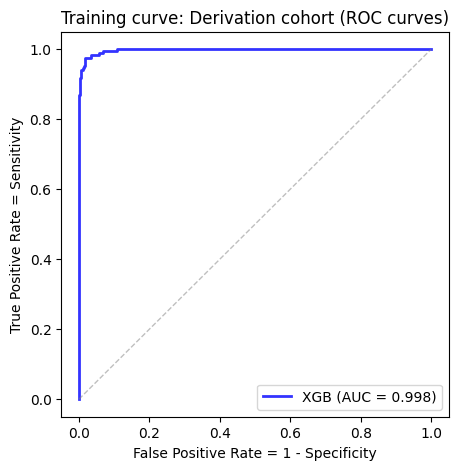

Training AUROC: 0.998 (95% CI: 0.996, 0.999)


In [15]:
# 1. Train the best model on the entire training set
best_xgb = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0,
        tree_method="hist",
        n_jobs=-1,
        random_state=42)

# Fit the model on the entire training set
best_xgb.fit(X_train, y_train)

# 2. Predict on training data
pred_probas_train = best_xgb.predict_proba(X_train)

# 3. Compute ROC curve and area under the curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)

# 4. Plot ROC curve
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# 5. Compute AUROC CI using bootstrap
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")
print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")

# 6. Save the model for future use
import pickle
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)


Validation Set Evaluation:


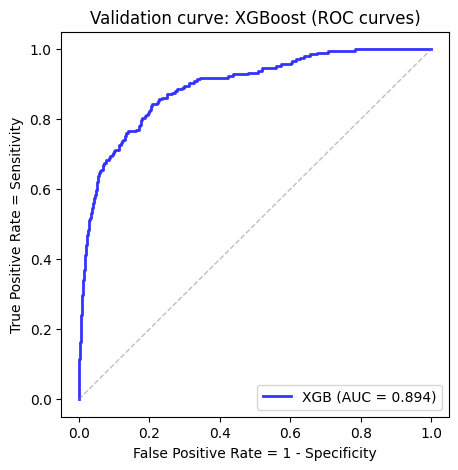

Validation AUROC: 0.894 (95% CI: 0.868, 0.916)


In [17]:
# Evaluate XGBoost model on validation set
print("\nValidation Set Evaluation:")
pred_probas_val = best_xgb.predict_proba(X_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)

# Plot the ROC curve
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Validation curve: XGBoost (ROC curves)')

# Compute AUROC CI using bootstrap
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

# Print results
print(f"Validation AUROC: {roc_auc_val:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")

External Validation (Test)


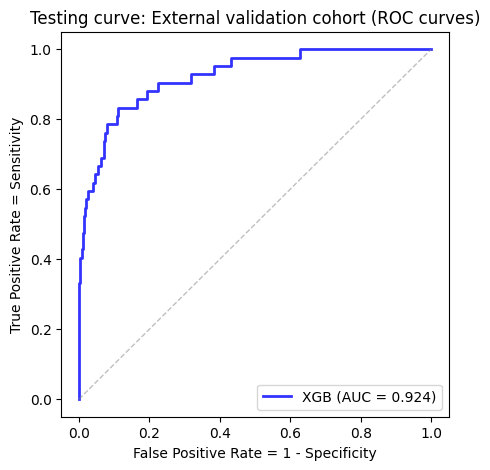

Val AUROC: 0.924 (95% CI: 0.878, 0.963)


In [18]:
print("External Validation (Test)")
pred_probas_test = best_xgb.predict_proba(X_test)
risk_groups_test = results(pred_probas_test)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probas_test[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: External validation cohort (ROC curves)')
#plot_Shapley(clf, X_test, columns, 'Derivation cohort', 25)
# Compute AUROC CI
auroc_ci_lower_test, auroc_ci_upper_test = bootstrap_metric_ci(y_test, pred_probas_test[:,1], "auroc")

print(f"Val AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_test:.3f}, {auroc_ci_upper_test:.3f})")